Implementing Heston model
1) dSt = mu * S * dt + sqrt(vt) * S * dWt where St is the asset value and Wt is a Standard Brownian Motion
vt is the volatility term that follows a square root process
2) dvt = kappa (theta - vt) * dt + sigma * sqrt(vt) * dWt^2
Wt^2 is the standard Brownian motion that has a correlation rho with Wt

In [2]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [3]:
# Initializing required variables

S0 = 100
v0 = 0.06
kappa = 9
theta = 0.06
r = 0.03
sigma = 0.5
rho = -0.4

# Strike and Time Period of Option
K = 105
T =  0.5
kLog = np.log(K)

#To approximate integrals
t_max = 30
N = 100
phi = norm.cdf

In [40]:
# Wrtiing characteristic function code
a = sigma**2/2

def b(u):
    return kappa - rho * sigma * 1j * u

def c(u):
    return -(u ** 2 + u * 1j) / 2

def d(u):
    return np.sqrt(b(u) ** 2 - 4 * a *c(u))

def xminus(u):
    return (b(u) - d(u)) / (2 * a)

def xplus(u):
    return (b(u) + d(u)) / (2 * a)

def g(u):
    return xminus(u) / xplus(u)

def C(u):
    val = T * xminus(u) - np.log((1 - g(u) * np.exp(-T * d(u))) / (1 - g(u))) / a
    return r * T * 1j * u + theta * kappa * val

def D(u):
    val1 = 1 - np.exp(-T * d(u))
    val2 = 1 - g(u) * np.exp(-T * d(u))
    return (val1/val2) * xminus(u)

def log_char(u):
    return np.exp(C(u) + D(u) * v0 + 1j * u * np.log(S0))

def adj_char(u):
    return log_char(u - 1j) / log_char(-1j)


In [41]:
delta_t = t_max / N
from_1_to_N = np.linspace(1,N,N)
t_n = (from_1_to_N - 1/2) * delta_t

In [42]:
# Estimating the integrals
first_integral = sum((((np.exp(-1j * t_n * kLog) * adj_char(t_n)).imag) / t_n) * delta_t)
second_integral = sum((((np.exp(-1j * t_n * kLog) * log_char(t_n)).imag) / t_n) * delta_t)

In [43]:
# Estimate fourier call price
fourier_call_value = S0 * (1/2 + first_integral/np.pi) - K * np.exp(-r * T) * (1/2 + second_integral/np.pi)

In [44]:
# Analytical solution
def analytical_price(S0,K,r,sigma,T):
    d1 = (np.log(S0 / K) + (r + sigma ** 2/2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * phi(d1) - K * np.exp(-r * T) * phi(d2)

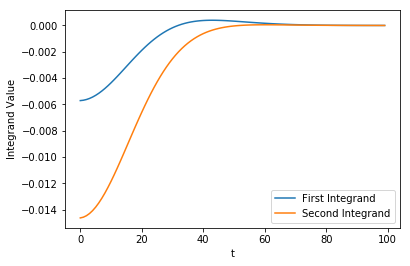

In [45]:
plt.plot(((((np.exp(-1j * t_n * kLog) * adj_char(t_n)).imag) / t_n) * delta_t),label = "First Integrand")
plt.plot(((((np.exp(-1j * t_n * kLog) * log_char(t_n)).imag) / t_n) * delta_t),label = "Second Integrand")
plt.legend()
plt.xlabel("t")
plt.ylabel("Integrand Value")
plt.show()